In [1]:
####### This part is about testing the final structure of the color identification, using siamese networks ##########
#######                               and histogram correlation                                            ##########

In [2]:
### Import libraries

import torch
import cv2
import time
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt


from bokeh.plotting import figure, show

from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# output_notebook()
import sys
sys.path.insert(1, r'C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC')

from functions import *
import posenet
from Person import Person, Unknown_Person
from Color import Color

VIDEO_PATH = r'C:\Users\TRMoussa-PCHP\OneDrive\PSC\videos'

output_video_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\output"

weigths_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\notebook\Deep_Model\weights"
output_histogram_path = r"C:\Users\TRMoussa-PCHP\OneDrive\PSC\psc\PSC\output_histogram"

In [3]:
### Constantes for trackers

PART_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
    ]

TARGETED_PART_IDS = [PART_NAMES.index(PART) for PART in ["rightShoulder", "leftHip",
                                                        "rightHip","leftShoulder"]]

Persons = []
num_pers = 2


In [4]:
## Load the posenet model

model = posenet.load_model(101)
model = model#.cuda()
output_stride = model.output_stride
scale_factor = 0.7125

## Function used to get all skeletons in one img, using posenet.
##
##  
def process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01):

    input_image, display_image, output_scale = posenet.utils._process_input(img, scale_factor=scale_factor, output_stride=output_stride)
    
    with torch.no_grad():
        input_image = torch.Tensor(input_image)#.cuda()

        heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = model(input_image)

        pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
            heatmaps_result.squeeze(0),
            offsets_result.squeeze(0),
            displacement_fwd_result.squeeze(0),
            displacement_bwd_result.squeeze(0),
            output_stride=output_stride,
            max_pose_detections=num_pose,
            min_pose_score=min_pose_score)
    
    keypoint_coords *= output_scale

    keypoint_coords = np.array(keypoint_coords)
    keypoint_scores = np.array(keypoint_scores)
    pose_scores = np.array(pose_scores)
    display_img = np.array(display_image)
    
    return display_image, keypoint_coords, keypoint_scores, pose_scores

In [5]:
##############    First method evaluation Tracking using the histogram correlation method     ################


In [6]:
## Class for Tracking using Histogram correlation
class Tracker_Correl:
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Correl.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]

        
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    print("histogram putted for person_{}".format(detected_pers+1))
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
            
        Dico_0, confidences_0 = self.person0.identifie_correl(self.frame, keypoint_list)
        Dico_1, confidences_1 = self.person1.identifie_correl(self.frame, keypoint_list)
        
        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        print("Person_0 correl_Score : {}". format(self.person0.prob))
        print("Person_1 correl_Score : {} \n". format(self.person1.prob))
        
        return self.frame
        
    def draw(self):
        self.person0.draw(self.frame, 4)
        self.person1.draw(self.frame, 2)
        return self.frame

Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


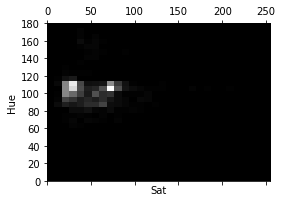

histogram putted for person_1
0.6215065805599571


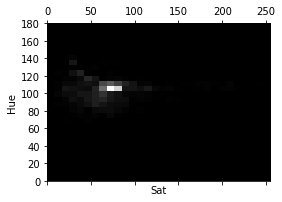

histogram putted for person_2
initialisation succed
Person_0 correl_Score : 0.9484566420494599
Person_1 correl_Score : 0.9793638254067849 

Person_0 correl_Score : 0.9911028101488952
Person_1 correl_Score : 0.876014051325741 

Person_0 correl_Score : 0.9587955975659
Person_1 correl_Score : 0.893106657191853 

Person_0 correl_Score : 0.949767890629128
Person_1 correl_Score : 0.9137183628049107 

Person_0 correl_Score : 0.9612351175328249
Person_1 correl_Score : 0.9726782370168607 

Person_0 correl_Score : 0.9827598648433404
Person_1 correl_Score : 0.9914826333184731 

Person_0 correl_Score : 0.9819034756579564
Person_1 correl_Score : 0.9350475895338027 

Person_0 correl_Score : 0.9760525481662178
Person_1 correl_Score : 0.9933745427952471 

Person_0 correl_Score : 0.9754397416907229
Person_1 correl_Score : 0.9853025479727358 

Person_0 correl_Score : 0.9762892270128269
Person_1 correl_Score : 0.9941511672217715 

Person_0 correl_Score : 0.990968278253317
Person_1 correl_Score : 0.995458

Person_0 correl_Score : 0.8309373126115804
Person_1 correl_Score : 0.4664022184268463 

Person_0 correl_Score : 0.8386485203687953
Person_1 correl_Score : 0.38099003231323425 

Person_0 correl_Score : 0.8386595989382368
Person_1 correl_Score : 0.6073344155630319 

Person_0 correl_Score : 0.8107817629651826
Person_1 correl_Score : 0.4477706771214512 

Person_0 correl_Score : 0.818805523280479
Person_1 correl_Score : 0.44560895947737533 

Person_0 correl_Score : 0.803954058022478
Person_1 correl_Score : 0.4221517460489315 

Person_0 correl_Score : 0.7695584966780856
Person_1 correl_Score : 0.3801567179912574 

Person_0 correl_Score : 0.8276703537234712
Person_1 correl_Score : 0.39585994986096573 

Person_0 correl_Score : 0.8344936146338406
Person_1 correl_Score : 0.4203615509950975 

Person_0 correl_Score : 0.8439654257190932
Person_1 correl_Score : 0.45112361606608603 

Person_0 correl_Score : 0.863499057014064
Person_1 correl_Score : 0.4573872647297305 

Person_0 correl_Score : 0.85260

Person_0 correl_Score : 0.4255727084246186
Person_1 correl_Score : 0.7864649205428935 

Person_0 correl_Score : 0.7266295096703214
Person_1 correl_Score : 0.7555424493678502 

Person_0 correl_Score : 0.4125740710539086
Person_1 correl_Score : 0.7633930952582789 

Person_0 correl_Score : 0.4633101529602462
Person_1 correl_Score : 0.6945338113533488 

Person_0 correl_Score : 0.45767080442087577
Person_1 correl_Score : 0.8160707318942568 

Person_0 correl_Score : 0.2940620233641672
Person_1 correl_Score : 0.7507740442419082 

Person_0 correl_Score : 0.33197410923309595
Person_1 correl_Score : 0.7465544086561046 

Person_0 correl_Score : 0.46989427329056627
Person_1 correl_Score : 0.8048795328461928 

Person_0 correl_Score : 0.5048088653152426
Person_1 correl_Score : 0.7755780314178975 

Person_0 correl_Score : 0.6279901961499345
Person_1 correl_Score : 0.7589490882164812 

Person_0 correl_Score : 0.5196290993779129
Person_1 correl_Score : 0.8232865508888157 

Person_0 correl_Score : 0.467

Person_0 correl_Score : 0.4164291761494815
Person_1 correl_Score : 0.81740424828693 

Person_0 correl_Score : 0.597182242723363
Person_1 correl_Score : 0.8481839498768593 

Person_0 correl_Score : 0.529434925183789
Person_1 correl_Score : 0.8480316101925163 

Person_0 correl_Score : 0.6339266661428351
Person_1 correl_Score : 0.8329959602307061 

Person_0 correl_Score : 0.6087068630933835
Person_1 correl_Score : 0.7830751701025682 

Person_0 correl_Score : 0.551195876469262
Person_1 correl_Score : 0.7653094514197681 

Person_0 correl_Score : 0.38875513887380686
Person_1 correl_Score : 0.800033360000419 

Person_0 correl_Score : 0.6140257925881876
Person_1 correl_Score : 0.810933618337966 

Person_0 correl_Score : 0.5637591675649389
Person_1 correl_Score : 0.7588203299066415 

Person_0 correl_Score : 0.7532722290710099
Person_1 correl_Score : 0.7409861796526561 

Person_0 correl_Score : 0.7733554336750386
Person_1 correl_Score : 0.7355610008762492 

Person_0 correl_Score : 0.322708610669

In [7]:
#####      Test of the method       ######
##########################################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_correl_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))

tracker = Tracker_Correl(path)

##### Initialisation of the tracker
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    frame_count += 1
    if( cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [7]:
# Load histograms for time evaluation

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit distance = dist = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL)

3.34 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
##############    Second method evaluation Tracking using the Siamese network method     ################


In [8]:
#### Fonctions used during training of the network for initialising weights and bias

def initialize_weights(shape, name = None, dtype = None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name = None, dtype = None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [9]:
### load the trained siamese network model for visualising

with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias}):
    loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_first.h5'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
loadded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         1382528     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [11]:
### Class for tracking using Siamese Network
class Tracker_Siamese:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Siamese.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_first.h5'))
        
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        
        Dico_0, confidences_0 = self.person0.identifie_model(self.frame, keypoint_list)
        Dico_1, confidences_1 = self.person1.identifie_model(self.frame, keypoint_list)

        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        print("One_Shot score Person_0 : {} ".format(self.person0.prob))
        print("One_Shot score Person_1 : {} \n".format(self.person1.prob))
        
        return self.frame
    
        
    def draw(self):
        img = self.person0.draw(self.frame, 4)
        img = self.person1.draw(self.frame, 2)
        #cv2.imshow('Track', img)
        return img
    
    

Model loadded
Model loadded
Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


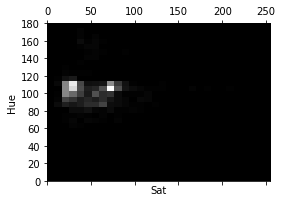

0.6215065805599571


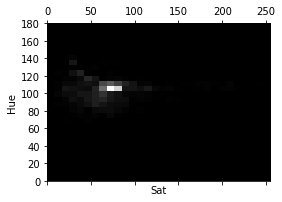

initialisation succed
One_Shot score Person_0 : 0.3707088828086853 
One_Shot score Person_1 : 0.2241838574409485 

One_Shot score Person_0 : 0.21342253684997559 
One_Shot score Person_1 : 0.19060450792312622 

One_Shot score Person_0 : 0.22847050428390503 
One_Shot score Person_1 : 0.31680721044540405 

One_Shot score Person_0 : 0.21722441911697388 
One_Shot score Person_1 : 0.3274420499801636 

One_Shot score Person_0 : 0.23531454801559448 
One_Shot score Person_1 : 0.24229657649993896 

One_Shot score Person_0 : 0.21561139822006226 
One_Shot score Person_1 : 0.2656005024909973 

One_Shot score Person_0 : 0.34352612495422363 
One_Shot score Person_1 : 0.3025668263435364 

One_Shot score Person_0 : 0.34849780797958374 
One_Shot score Person_1 : 0.2953096628189087 

One_Shot score Person_0 : 0.3725348114967346 
One_Shot score Person_1 : 0.18110054731369019 

One_Shot score Person_0 : 0.36875200271606445 
One_Shot score Person_1 : 0.16190117597579956 

One_Shot score Person_0 : 0.3503583

One_Shot score Person_0 : 0.28847193717956543 
One_Shot score Person_1 : 0.2934739589691162 

One_Shot score Person_0 : 0.29347938299179077 
One_Shot score Person_1 : 0.3025721311569214 

One_Shot score Person_0 : 0.32872503995895386 
One_Shot score Person_1 : 0.32026177644729614 

One_Shot score Person_0 : 0.29122573137283325 
One_Shot score Person_1 : 0.3645440936088562 

One_Shot score Person_0 : 0.18781542778015137 
One_Shot score Person_1 : 0.34752535820007324 

One_Shot score Person_0 : 0.09992474317550659 
One_Shot score Person_1 : 0.2896271347999573 

One_Shot score Person_0 : 0.11489623785018921 
One_Shot score Person_1 : 0.3126593232154846 

One_Shot score Person_0 : 0.1973438262939453 
One_Shot score Person_1 : 0.3227840065956116 

One_Shot score Person_0 : 0.271848201751709 
One_Shot score Person_1 : 0.3238673806190491 

One_Shot score Person_0 : 0.2612497806549072 
One_Shot score Person_1 : 0.2547093629837036 

One_Shot score Person_0 : 0.3168267607688904 
One_Shot score P

One_Shot score Person_0 : 0.06449562311172485 
One_Shot score Person_1 : 0.06723082065582275 

One_Shot score Person_0 : 0.1817367672920227 
One_Shot score Person_1 : 0.1567925214767456 

One_Shot score Person_0 : 0.3875870108604431 
One_Shot score Person_1 : 0.2731151580810547 

One_Shot score Person_0 : 0.24165332317352295 
One_Shot score Person_1 : 0.15844595432281494 

One_Shot score Person_0 : 0.371743381023407 
One_Shot score Person_1 : 0.2585664391517639 

One_Shot score Person_0 : 0.2863723635673523 
One_Shot score Person_1 : 0.20355892181396484 

One_Shot score Person_0 : 0.13173729181289673 
One_Shot score Person_1 : 0.2074880599975586 

One_Shot score Person_0 : 0.09081834554672241 
One_Shot score Person_1 : 0.16718757152557373 

One_Shot score Person_0 : 0.09617650508880615 
One_Shot score Person_1 : 0.18382954597473145 

One_Shot score Person_0 : 0.13818764686584473 
One_Shot score Person_1 : 0.21646076440811157 

One_Shot score Person_0 : 0.14914226531982422 
One_Shot sco

One_Shot score Person_0 : 0.02187138795852661 
One_Shot score Person_1 : 0.1591724157333374 

One_Shot score Person_0 : 0.1952037811279297 
One_Shot score Person_1 : 0.04025447368621826 

One_Shot score Person_0 : 0.020013511180877686 
One_Shot score Person_1 : 0.13905596733093262 

One_Shot score Person_0 : 0.0215795636177063 
One_Shot score Person_1 : 0.15452826023101807 

One_Shot score Person_0 : 0.029629111289978027 
One_Shot score Person_1 : 0.1546204686164856 

One_Shot score Person_0 : 0.049508094787597656 
One_Shot score Person_1 : 0.19399875402450562 

One_Shot score Person_0 : 0.1621403694152832 
One_Shot score Person_1 : 0.17665398120880127 

One_Shot score Person_0 : 0.09729182720184326 
One_Shot score Person_1 : 0.24164152145385742 

One_Shot score Person_0 : 0.08847677707672119 
One_Shot score Person_1 : 0.3461782932281494 

One_Shot score Person_0 : 0.1857924461364746 
One_Shot score Person_1 : 0.18540072441101074 

One_Shot score Person_0 : 0.19273513555526733 
One_Sho

In [14]:
##### Test of the method ######
###############################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_siamese_first_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))
#cv2.namedWindow('Track')

tracker = Tracker_Siamese(path)

##### Initialisation of the tracker
tracker.load_model()
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    frame_count += 1
    if(cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [13]:
# Load histograms for time evaluation

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit prediction = tracker.model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])

NameError: name 'tracker' is not defined

In [12]:
### Same method with a different Siamese network model

In [13]:
#### Fonctions used during training of the network for initialising weights and bias

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [14]:
from tensorflow.keras.utils import CustomObjectScope
#help(tf.keras.initialisations)
with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
    loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))

In [15]:
loadded_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 30, 30, 1)]  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128)          148352      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]              

In [16]:
### Class for tracking using Siamese Network
class Tracker_Siamese_Second:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Siamese_Second.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))
        
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        
        Dico_0, confidences_0 = self.person0.identifie_model(self.frame, keypoint_list)
        Dico_1, confidences_1 = self.person1.identifie_model(self.frame, keypoint_list)

        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        print("One_Shot score Person_0 : {} ".format(self.person0.prob))
        print("One_Shot score Person_1 : {} \n".format(self.person1.prob))
        
        return self.frame
    
        
    def draw(self):
        img = self.person0.draw(self.frame, 4)
        img = self.person1.draw(self.frame, 2)
        #cv2.imshow('Track', img)
        return img
    
    

Model loadded
Model loadded
Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


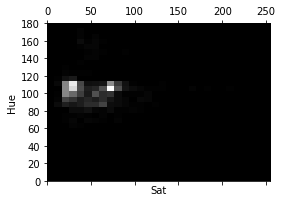

0.6215065805599571


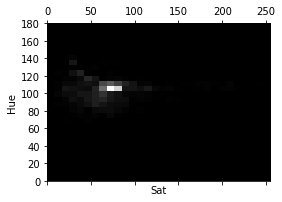

initialisation succed
One_Shot score Person_0 : 0.7495158910751343 
One_Shot score Person_1 : 0.9683666080236435 

One_Shot score Person_0 : 0.6329721510410309 
One_Shot score Person_1 : 0.8037653565406799 

One_Shot score Person_0 : 0.8343900740146637 
One_Shot score Person_1 : 0.7894495725631714 

One_Shot score Person_0 : 0.8349492996931076 
One_Shot score Person_1 : 0.7866817116737366 

One_Shot score Person_0 : 0.7931532710790634 
One_Shot score Person_1 : 0.8425491750240326 

One_Shot score Person_0 : 0.8346261084079742 
One_Shot score Person_1 : 0.8804664611816406 

One_Shot score Person_0 : 0.8094110637903214 
One_Shot score Person_1 : 0.9776443243026733 

One_Shot score Person_0 : 0.8213649392127991 
One_Shot score Person_1 : 0.9383768662810326 

One_Shot score Person_0 : 0.789003387093544 
One_Shot score Person_1 : 0.8900371864438057 

One_Shot score Person_0 : 0.8040235191583633 
One_Shot score Person_1 : 0.8782865405082703 

One_Shot score Person_0 : 0.8127637207508087 
One

One_Shot score Person_0 : 0.7524654418230057 
One_Shot score Person_1 : 0.4907032251358032 

One_Shot score Person_0 : 0.7789517790079117 
One_Shot score Person_1 : 0.7537830322980881 

One_Shot score Person_0 : 0.7378361821174622 
One_Shot score Person_1 : 0.5710577666759491 

One_Shot score Person_0 : 0.7197096943855286 
One_Shot score Person_1 : 0.3404049277305603 

One_Shot score Person_0 : 0.7264567911624908 
One_Shot score Person_1 : -0.023049473762512207 

One_Shot score Person_0 : 0.6989721953868866 
One_Shot score Person_1 : -0.3105137348175049 

One_Shot score Person_0 : 0.7155420482158661 
One_Shot score Person_1 : -0.3232293128967285 

One_Shot score Person_0 : 0.7377081513404846 
One_Shot score Person_1 : -0.005284786224365234 

One_Shot score Person_0 : 0.8036929219961166 
One_Shot score Person_1 : -0.014011025428771973 

One_Shot score Person_0 : 0.7849447876214981 
One_Shot score Person_1 : 0.008784353733062744 

One_Shot score Person_0 : 0.8286882191896439 
One_Shot sc

One_Shot score Person_0 : -0.12708330154418945 
One_Shot score Person_1 : 0.23868757486343384 

One_Shot score Person_0 : -0.11011207103729248 
One_Shot score Person_1 : 0.23818856477737427 

One_Shot score Person_0 : 0.0013561844825744629 
One_Shot score Person_1 : 0.6210262179374695 

One_Shot score Person_0 : -0.03290438652038574 
One_Shot score Person_1 : 0.4519655108451843 

One_Shot score Person_0 : -0.05407154560089111 
One_Shot score Person_1 : 0.5641466677188873 

One_Shot score Person_0 : 0.46802282333374023 
One_Shot score Person_1 : 0.6016902923583984 

One_Shot score Person_0 : 0.3009568452835083 
One_Shot score Person_1 : 0.9968695640563965 

One_Shot score Person_0 : 0.20690417289733887 
One_Shot score Person_1 : 0.9688111618161201 

One_Shot score Person_0 : 0.4098966717720032 
One_Shot score Person_1 : 0.9857059549540281 

One_Shot score Person_0 : 0.4396880865097046 
One_Shot score Person_1 : 0.8810481876134872 

One_Shot score Person_0 : 0.4882698655128479 
One_Shot 

One_Shot score Person_0 : -0.09126174449920654 
One_Shot score Person_1 : 0.6499930024147034 

One_Shot score Person_0 : -0.07614922523498535 
One_Shot score Person_1 : 0.5317595303058624 

One_Shot score Person_0 : 0.3547576665878296 
One_Shot score Person_1 : -0.494290828704834 

One_Shot score Person_0 : -0.09688293933868408 
One_Shot score Person_1 : 0.6217161417007446 

One_Shot score Person_0 : -0.07964944839477539 
One_Shot score Person_1 : 0.5314427018165588 

One_Shot score Person_0 : -0.08365476131439209 
One_Shot score Person_1 : 0.8810242414474487 

One_Shot score Person_0 : 0.02065908908843994 
One_Shot score Person_1 : 0.9980609853519127 

One_Shot score Person_0 : 0.3605195879936218 
One_Shot score Person_1 : 0.8159319758415222 

One_Shot score Person_0 : 0.4242483973503113 
One_Shot score Person_1 : 0.9103283435106277 

One_Shot score Person_0 : 0.014581501483917236 
One_Shot score Person_1 : 0.6955010294914246 

One_Shot score Person_0 : -0.08476018905639648 
One_Shot 

In [21]:
##### Test of the method ######
###############################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_siamese_second_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))
#cv2.namedWindow('Track')

tracker = Tracker_Siamese_Second(path)

##### Initialisation of the tracker
tracker.load_model()
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    frame_count += 1
    if(cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [22]:
# Load histograms for time evaluation

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit prediction = tracker.model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])

3.6 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
##############    Third method evaluation Tracking using the Siamese network method     ################
##############    This is the final method that will be use in our project              ################


In [18]:
## Hyper Parameter
lambda_factor = 0.8

In [19]:
### Class for tracking using Siamese Network
class Tracker_Final:
    
    num_pers = 2
    
    def __init__(self, videopath):
        self.num_pers = Tracker_Final.num_pers
        self.cap = cv2.VideoCapture(videopath)
        self.frame = None
        
        self.person0 = Person('Person', '0')
        self.person1 = Person('Person', '1')
        
        self.persons = [self.person0, self.person1]
        
        self.model = None

    def load_model(self):
        
        ## Load the model as above
        with CustomObjectScope({'initialize_weights':initialize_weights,'initialize_bias':initialize_bias,
                       'contrastive_loss': contrastive_loss}):
            loadded_model = load_model(os.path.join(weigths_path, 'model_siamese_second.h5'))
            
        self.model = loadded_model
        
        for i in range(len(self.persons)):
            self.persons[i].load_model(loadded_model)
    
    def initialise(self):
        print('Begin initialisation')
        begin = time.time()
        detected_pers = 0
        while True:
            _, img =self.cap.read()
            img = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
            display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(img, num_pose=2, min_pose_score=0.01, min_part_score=0.01)
            
            keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                                TARGETED_PART_IDS, self.num_pers,
                                                min_pose_confidence=0.01, min_part_confidence=0.01)
            print(keypoint_list)
            
            for i, coords in enumerate(keypoint_list):
                
                
                if not contains_pers(display_image, self.persons, coords, crit=0.70) and i<self.num_pers:
                    self.persons[detected_pers].put_histogram(display_image, coords)
                    #print(type(perform_histogram(display_image, coords)))
                    detected_pers += 1
                    
            if(detected_pers == self.num_pers):
                break
            delta = int(time.time()-begin)  
            if(delta==120):
                raise Exeption('Initialisation failed')
        print('initialisation succed')
    
    
    def update(self):
        _,img = self.cap.read()
        self.frame = cv2.resize(img, None, fx=0.4, fy=0.4, interpolation = cv2.INTER_LINEAR)
        display_image, keypoint_coords, keypoint_scores, pose_scores = process_posenet(self.frame, num_pose=2, min_pose_score=0.1, min_part_score=0.10)
            
        keypoint_list = get_correct_coords(pose_scores, keypoint_scores, keypoint_coords,
                                            TARGETED_PART_IDS, self.num_pers,
                                            min_pose_confidence=0.01, min_part_confidence=0.01)
        
        Dico_0, confidences_0 = self.person0.identifie_cross_2(self.frame, keypoint_list, lambda_factor)
        Dico_1, confidences_1 = self.person1.identifie_cross_2(self.frame, keypoint_list, lambda_factor)
        
        conf_0, conf_1 = link_confidences([confidences_0, confidences_1])
        
        self.person0.update(Dico_0[conf_0], conf_0)
        self.person1.update(Dico_1[conf_1], conf_1)
        
        #print(a==None,b==None)
        print("Mixed_Score for person_0 : {}".format(self.person0.prob))
        print("Mixed_Score for person_1 : {}".format(self.person1.prob))
        
        return self.frame
    
    def draw(self):
        img = self.person0.draw(self.frame, 5)
        img = self.person1.draw(self.frame, 2)
        #cv2.imshow('Track', img)
        return img
    
    

Model loadded
Model loadded
Begin initialisation
[]
[[array([123.22057105, 209.6332681 ]), array([171.07730988, 228.19505522])], [array([130.0887093 , 269.92120275]), array([176.70279231, 298.34396959])]]


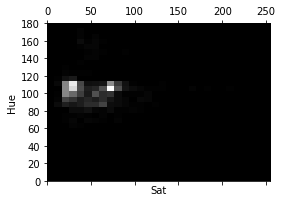

0.6215065805599571


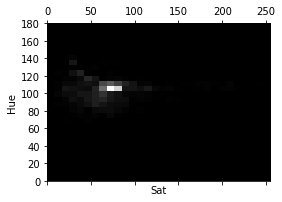

initialisation succed
size :  4
[0.7893040412699994, 0.9705660515002719]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.7893040412699994
Mixed_Score for person_1 : 0.9705660515002719
size :  4
[0.6949200237896784, 0.8182150954976921]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.6949200237896784
Mixed_Score for person_1 : 0.8182150954976921
size :  4
[0.8544841202780621, 0.8101809894889077]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.8544841202780621
Mixed_Score for person_1 : 0.8101809894889077
size :  4
[0.8588344786399689, 0.8120890418999714]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.8588344786399689
Mixed_Score for person_1 : 0.8120890418999714
size :  4
[0.8138505932543507, 0.8651421232733013]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.8138505932543507
Mixed_Score for person_1 : 0.8651421232733013
size :  4
[0.8477286768194021, 0.8913763126941974]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.847

size :  4
[0.7166407991612707, 0.7382407018307867]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.7166407991612707
Mixed_Score for person_1 : 0.7382407018307867
size :  4
[0.7154784894166366, 0.9543947395196313]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.7154784894166366
Mixed_Score for person_1 : 0.9543947395196313
size :  4
[0.6743319014883081, 0.8164300119766348]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.6743319014883081
Mixed_Score for person_1 : 0.8164300119766348
size :  4
[0.6759308508760313, 0.8201574823997294]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.6759308508760313
Mixed_Score for person_1 : 0.8201574823997294
Mixed_Score for person_0 : 0.7548457924432312
Mixed_Score for person_1 : 0.1818082305297703
Mixed_Score for person_0 : 0.7425706004775438
Mixed_Score for person_1 : 0.17217172552799145
Mixed_Score for person_0 : 0.7491366306492149
Mixed_Score for person_1 : 0.22596216622144277
Mixed_Score for person_0 : 0.7

Mixed_Score for person_0 : 0.8488551142068302
Mixed_Score for person_1 : 0.09389465359628606
Mixed_Score for person_0 : 0.8096446367208534
Mixed_Score for person_1 : 0.08482462343825593
Mixed_Score for person_0 : 0.8353389977153255
Mixed_Score for person_1 : 0.06786329448301232
Mixed_Score for person_0 : 0.7898311766699212
Mixed_Score for person_1 : 0.06646751404972846
size :  4
[0.786254192195174, -10]
Before 0 0
0 0
size :  1
[0.786254192195174, -0.02234190760955633]
Before 0 0
0 0
Mixed_Score for person_0 : 0.786254192195174
Mixed_Score for person_1 : -0.02234190760955633
size :  4
[0.8287440760180688, -10]
Before 0 0
0 0
size :  1
[0.8287440760180688, -0.017530243192952377]
Before 0 0
0 0
Mixed_Score for person_0 : 0.8287440760180688
Mixed_Score for person_1 : -0.017530243192952377
size :  4
[0.8119145513886007, 0.2040131603516337]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.8119145513886007
Mixed_Score for person_1 : 0.2040131603516337
size :  4
[0.8083972549351849,

Mixed_Score for person_0 : 0.13194903934686714
Mixed_Score for person_1 : 0.7471402588834096
Mixed_Score for person_0 : 0.1287786346858091
Mixed_Score for person_1 : 0.8680670258493648
Mixed_Score for person_0 : 0.1300852465603296
Mixed_Score for person_1 : 0.7796200779070358
Mixed_Score for person_0 : 0.06810832081190203
Mixed_Score for person_1 : 0.47084161125167245
Mixed_Score for person_0 : 0.0030448787154060547
Mixed_Score for person_1 : 0.31158606493601054
Mixed_Score for person_0 : -0.00023244402859101676
Mixed_Score for person_1 : 0.260851281310393
Mixed_Score for person_0 : 0.016158580796764813
Mixed_Score for person_1 : 0.36194547650974007
Mixed_Score for person_0 : 0.013706420031837585
Mixed_Score for person_1 : 0.3704922769832718
Mixed_Score for person_0 : 0.088177571559212
Mixed_Score for person_1 : 0.6673927263572502
Mixed_Score for person_0 : 0.04051873736166964
Mixed_Score for person_1 : 0.5151027377886739
size :  4
[-10, 0.6025476824396244]
Before 1 0
1 0
size :  1
[0.

size :  4
[0.5235805427099568, 0.6536374400251078]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.5235805427099568
Mixed_Score for person_1 : 0.6536374400251078
size :  4
[0.4938735125340576, 0.6343163738959865]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.4938735125340576
Mixed_Score for person_1 : 0.6343163738959865
size :  4
[0.31843701847661743, 0.26314003664926605]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.31843701847661743
Mixed_Score for person_1 : 0.26314003664926605
size :  4
[0.5968254166076132, 0.1844486570409562]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.5968254166076132
Mixed_Score for person_1 : 0.1844486570409562
size :  4
[0.4457916100250492, 0.22736826791470066]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.4457916100250492
Mixed_Score for person_1 : 0.22736826791470066
Mixed_Score for person_0 : 0.0024052941720138638
Mixed_Score for person_1 : 0.20559713310974992
size :  4
[0.4532810816737016, 0.

size :  4
[0.12190802988770622, 0.9684992688222875]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.12190802988770622
Mixed_Score for person_1 : 0.9684992688222875
size :  4
[0.5152576877512468, 0.9039816180926497]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.5152576877512468
Mixed_Score for person_1 : 0.9039816180926497
size :  4
[0.1671059002832712, 0.9166713432546754]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.1671059002832712
Mixed_Score for person_1 : 0.9166713432546754
size :  4
[0.31780263797904074, 0.48311594947816716]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.31780263797904074
Mixed_Score for person_1 : 0.48311594947816716
size :  4
[0.4187348183177413, 0.7350527277602129]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.4187348183177413
Mixed_Score for person_1 : 0.7350527277602129
size :  4
[0.4516335218385059, 0.5302224657215129]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.4516335218385059
Mi

Mixed_Score for person_0 : 0.07376894966660388
Mixed_Score for person_1 : 0.8065036425137566
size :  4
[0.09617986145903976, 0.7769101064876778]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.09617986145903976
Mixed_Score for person_1 : 0.7769101064876778
Mixed_Score for person_0 : 0.07516726618529723
Mixed_Score for person_1 : 0.8224694657428494
Mixed_Score for person_0 : 0.08117231967007543
Mixed_Score for person_1 : 0.8266085237071759
size :  4
[-10, 0.6925343443940826]
Before 1 0
1 0
size :  1
[0.08524255721314727, 0.6925343443940826]
Before 0 0
0 0
Mixed_Score for person_0 : 0.08524255721314727
Mixed_Score for person_1 : 0.6925343443940826
size :  4
[0.24551468038683316, 0.7590273958164063]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.24551468038683316
Mixed_Score for person_1 : 0.7590273958164063
size :  4
[0.37001987934088315, 0.6613713280903338]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.37001987934088315
Mixed_Score for person_1 : 0.66

size :  4
[0.6333663838545862, -10]
Before 0 0
0 0
size :  1
[0.6333663838545862, 0.01005698235382265]
Before 0 0
0 0
Mixed_Score for person_0 : 0.6333663838545862
Mixed_Score for person_1 : 0.01005698235382265
size :  4
[0.4545838244424474, -10]
Before 0 1
0 1
size :  1
[0.4545838244424474, -0.019641876354515544]
Before 0 0
0 0
Mixed_Score for person_0 : 0.4545838244424474
Mixed_Score for person_1 : -0.019641876354515544
size :  4
[0.38314618923834154, -10]
Before 0 0
0 0
size :  1
[0.38314618923834154, -0.04606683159134198]
Before 0 0
0 0
Mixed_Score for person_0 : 0.38314618923834154
Mixed_Score for person_1 : -0.04606683159134198
size :  4
[0.6069335965556936, -10]
Before 0 0
0 0
size :  1
[0.6069335965556936, 0.14027172293688184]
Before 0 0
0 0
Mixed_Score for person_0 : 0.6069335965556936
Mixed_Score for person_1 : 0.14027172293688184
size :  4
[0.6487733592965934, 0.36160830747279926]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.6487733592965934
Mixed_Score for per

size :  4
[0.5294869775715437, -10]
Before 0 0
0 0
size :  1
[0.5294869775715437, 0.20175105690331757]
Before 0 0
0 0
Mixed_Score for person_0 : 0.5294869775715437
Mixed_Score for person_1 : 0.20175105690331757
size :  4
[0.5697562268922849, -10]
Before 0 0
0 0
size :  1
[0.5697562268922849, 0.18896318286056263]
Before 0 0
0 0
Mixed_Score for person_0 : 0.5697562268922849
Mixed_Score for person_1 : 0.18896318286056263
size :  4
[0.6300179063110958, 0.32037050206153556]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.6300179063110958
Mixed_Score for person_1 : 0.32037050206153556
size :  4
[0.6614807155713872, 0.23062053427801343]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.6614807155713872
Mixed_Score for person_1 : 0.23062053427801343
size :  4
[0.5900116238251968, 0.21484010865525252]
Before 0 0
0 0
Before 1 1
0 0
Mixed_Score for person_0 : 0.5900116238251968
Mixed_Score for person_1 : 0.21484010865525252
size :  4
[0.6371547005409403, 0.21917036068123932]
B

size :  4
[0.5106483062849884, 0.6327673406843217]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.5106483062849884
Mixed_Score for person_1 : 0.6327673406843217
size :  4
[0.3654936219974677, 0.6234302494054211]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.3654936219974677
Mixed_Score for person_1 : 0.6234302494054211
size :  4
[0.5540555903479492, -10]
Before 0 0
0 0
size :  1
[0.5540555903479492, 0.22978041197120808]
Before 0 0
0 0
Mixed_Score for person_0 : 0.5540555903479492
Mixed_Score for person_1 : 0.22978041197120808
size :  4
[0.4490733827046073, 0.41369981823058743]
Before 1 0
1 0
Before 0 1
0 0
Mixed_Score for person_0 : 0.4490733827046073
Mixed_Score for person_1 : 0.41369981823058743
size :  4
[-10, 0.44178531691658096]
Before 1 0
1 0
size :  1
[0.23731700007680787, 0.44178531691658096]
Before 0 0
0 0
Mixed_Score for person_0 : 0.23731700007680787
Mixed_Score for person_1 : 0.44178531691658096
size :  4
[0.46773634170291767, -10]
Before 0 0
0 0
si

In [21]:
##### Test of the method ######
###############################

#### path of the video
path = VIDEO_PATH+r'\Duo_2.wmv'
videoWriter = cv2.VideoWriter(os.path.join(output_video_path,"test_cross_300.mp4"),cv2.VideoWriter_fourcc('I','4','2','0'),10,(512,288))
#cv2.namedWindow('Track')

tracker = Tracker_Final(path)

##### Initialisation of the tracker
tracker.load_model()
tracker.initialise()

#### Tracking phase
frame_count = 0
while True:
    img = tracker.update()
    img = tracker.draw()
    videoWriter.write(img)
    cv2.imshow('Track', img)
    #frame_count += 1
    if(cv2.waitKey(1) == ord('q') or frame_count == 300):
        videoWriter.release()
        cv2.destroyAllWindows()
        break


In [37]:
# Load histograms for time evaluation

def correl_and_predict(tracker, hist_1, hist_2):
    prediction = tracker.model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])
    distance = dist = cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL)

hist_1 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_1.png"), 0).astype(np.float32) / 255
hist_2 = cv2.imread(os.path.join(output_histogram_path, "hist_Person_0_18.png"), 0).astype(np.float32) / 255

%timeit correl_and_predict(tracker, hist_1, hist_2)

3.64 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
### Plot test datas for method evaluations

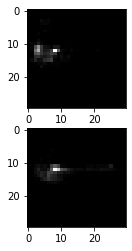

In [75]:
hist_1 = cv2.imread(os.path.join(output_histogram_path,"hist_Person_0_1.png"), 0)
hist_2 = cv2.imread(os.path.join(output_histogram_path,"hist_Person_1_16.png"), 0)

hist_1 = hist_1.astype(np.float32) / 255
hist_2 = hist_2.astype(np.float32) / 255

plt.subplot(211)
plt.imshow(hist_1 , cmap = plt.cm.gray)
plt.subplot(212)
plt.imshow(hist_2 , cmap = plt.cm.gray)

In [77]:

loadded_model.predict([hist_1.reshape(1,30,30,1), hist_2.reshape(1,30,30,1)])


array([[0.75836897]], dtype=float32)

In [80]:
cv2.compareHist(hist_1, hist_2, cv2.HISTCMP_CORREL) 

0.7100689877365118